# Analyzing NYC High School Data:
For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of <mark>800</mark> points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. We combined the following data sets into a single, clean pandas dataframe:
* **SAT scores by school** - SAT scores for each high school in New York City
* **School attendance** - Attendance information for each school in New York City
* **Class size** - Information on class size for each school
* **AP test results** - Advanced Placement (AP) exam results for each high school  (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* **Graduation outcomes** - The percentage of students who graduated, and other outcome information
* **Demographics** - Demographic information for each school
* **School survey** - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

We began performing some analysis. We'll extend that analysis in this project. As you can see, we've included the code to read in all of the data, combine it, and create correlations in the notebook.
The dataframe <mark>combined</mark> contains all of the data we'll be using in our analysis.
the data dictionary that's part of the zip file, can be downloaded from [the City of New York's website](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8).
   

# Read in the data

In [32]:
#import libraries and adjusting the environment
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [34]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [35]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [36]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [37]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [38]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [39]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [40]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [41]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

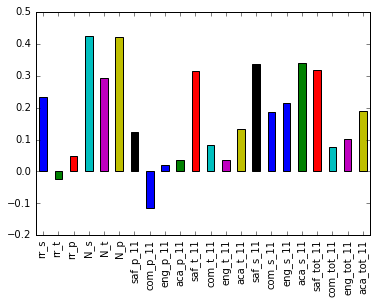

In [42]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
#plotting correlations with sat_score
combined.corr()["sat_score"][survey_fields].plot.bar()

## First thoughts
From the above plot we notice high correlation between <mark>N_s</mark>, <mark>N_t</mark>, <mark>N_p</mark> and <mark>sat_score<mark>.\n",
These columns are correlated with total_enrollment, causing correlation with SAT score.

<mark>rr_s</mark>, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. as it becomes more likely that students who are doing well academically to engage more in filling out surveys.

<mark>saf_t_11</mark> and <mark>saf_s_11</mark>, How students and teachers percieved safety correlates with sat_score. As it's hard to teach or learn in an unsafe environment and do well academically.

However correlation doesn't always align between students and teachers, interesting correlation is the <mark>aca_s_11</mark>, which indicates how the student perceives academic standards, correlates with SAT Score, but for <mark>aca_t_11</mark>, which how teachers perceive academic standards, or <mark>aca_p_11</mark>, how parents perceive academic standards which they doesn't correlate as high.   

# Exploring Safety and SAT Scores

<mark>saf_t_11</mark> and <mark>saf_s_11</mark>, which measure how teachers and students perceive safety at school, correlated highly with <mark>sat_score</mark>. We'll dig deeper into this relationship a bit more, and try to figure out which schools have low safety scores

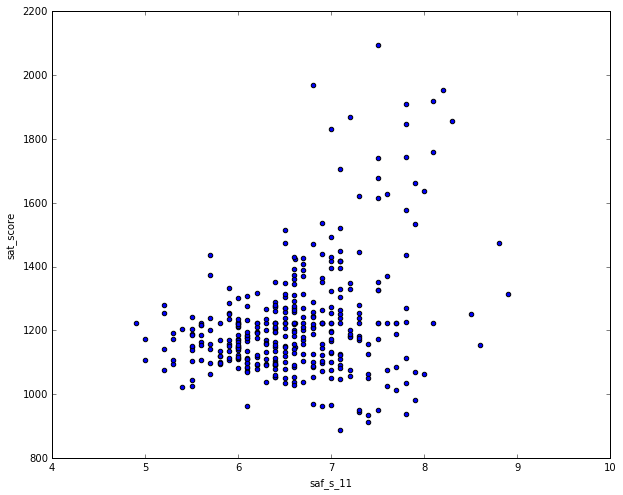

In [43]:
#plotting correlations with sat_score
combined.plot.scatter("saf_s_11","sat_score",figsize = (10, 8))

there is a moderate relation between safety and SAT Score, although it isn't so strong. However there are few schools with very high Safety and SAT scores on the other side few schools with low safety and SAT scores. 
Apparently no school with low safety score (< 6.5) has a high SAT score (> 1500).

## Safety scores by district.

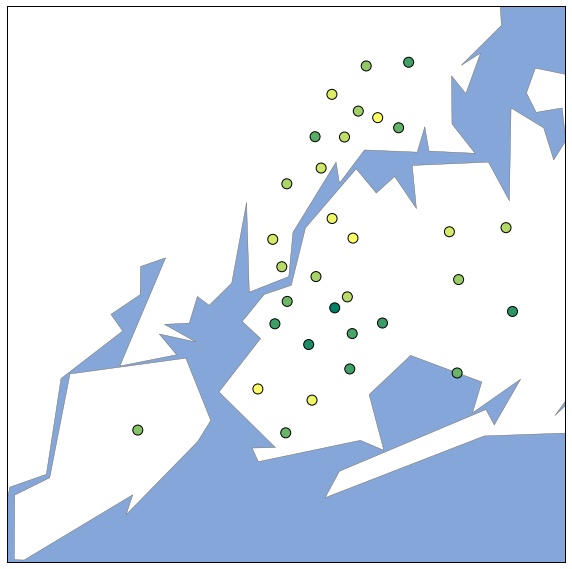

In [44]:
from mpl_toolkits.basemap import Basemap
#grouping districts and aggregate by district
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
plt.figure(figsize=(10,10))
#map snappet
m = Basemap(
    projection='merc',
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
    )
#boundries and colors
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
#positions
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
#plot our map
m.scatter(longitudes, latitudes, s=100, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer"),
plt.show()

Some areas have higher safety scores for example upper Manhattan and some parts of Queens, other areas have lower safety scores as Brooklyn.

# Exploring Race and SAT Scores

Races are divided among four races at a given school in our dataset as percentage:
* <mark>white_per</mark>
* <mark>asian_per</mark>
* <mark>black_per</mark>
* <mark>hispanic_per</mark>

let's see how different races perform in SAT

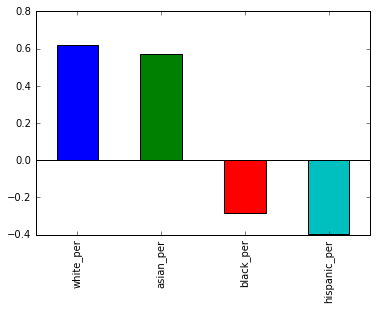

In [45]:
#correlation plot
races= ["white_per","asian_per","black_per","hispanic_per"]
plt.axhline(y=0,color='black',linestyle='-')
combined.corr()["sat_score"][races].plot.bar()

It appears that a higher percentage of white or asian students at a school correlates positively with sat score, performing better at SAT scores, in contrast a higher percentage of black or hispanic students correlates negatively with SAT score, perfororming worse in comparison to their white and asian counterparts. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

## Hispanic and SAT score
let's focus a bit on the Hispanic race.

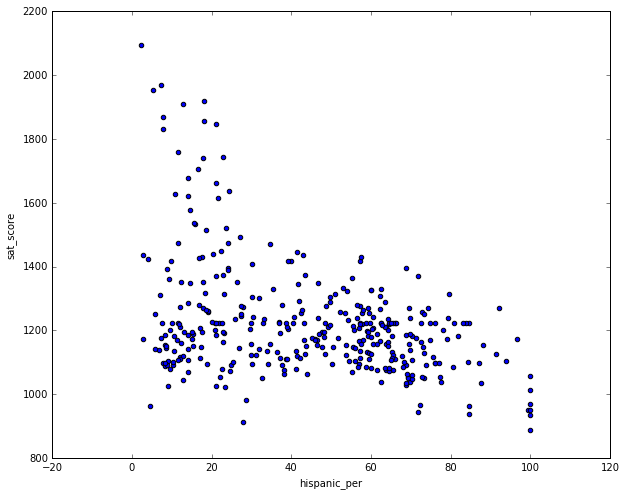

In [46]:
combined.plot.scatter("hispanic_per", "sat_score",figsize = (10, 8))

A negative relation is noticed emphasizing as the percentage of the hispanic origin students increase the SAT score decreases.

In [47]:
# schools with hispanic_per greater than 95%.
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After researching about these schools.
The schools listed above appear to be primarily to serve recent immigrants to the US. These schools have a lot of students who are learning English since their mother tongue is not English, which would explain the lower SAT scores among these schools.

In [48]:
print(combined[(combined["hispanic_per"] < 10) &
               (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After looking up about these schools. Most of these schools specialized in science and technology, known as STEM orianted receive extra funding, and only admit students who pass an entrance exam, tougher filtering process. This explain why their students tend to do better on the SAT score however this fully captures the reasons why low hispanic race among those schools.

# Exploring Gender and SAT Scores
There are two columns that indicate the percentage of each gender at a school:
* <mark>male_per</mark>
* <mark>female_per</mark>

let's move in this direction and see what hides in that.

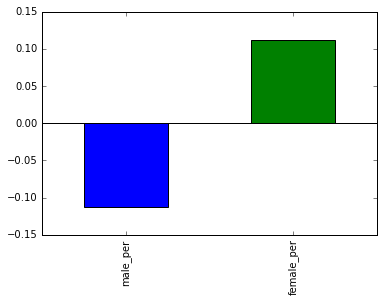

In [49]:
gender_fields=["male_per","female_per"]
plt.axhline(y=0,color='black',linestyle='-')
combined.corr()["sat_score"][gender_fields].plot.bar()

There is a weak correlation between gender and SAT score. which in case of female it is positive in contrast to male which is negative in that case.

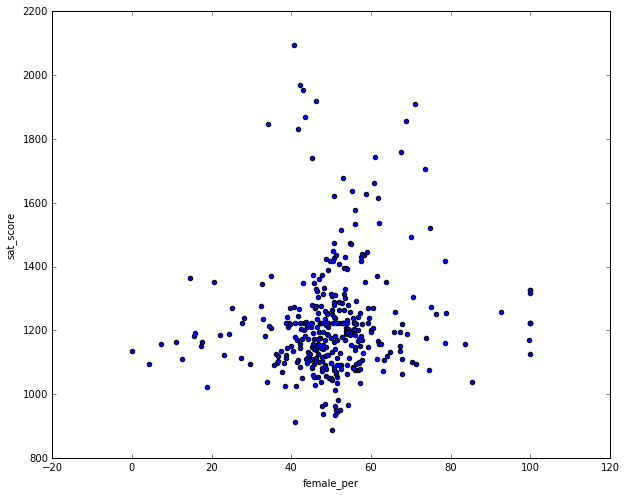

In [50]:
combined.plot.scatter("female_per","sat_score",figsize = (10, 8))

There doesn't seem to be any real correlation between genders percentage and SAT score. noticeably, there is a some schools with a high percentage of females (60% to 80%) and high SAT scores.

In [51]:
#schools with high female percentage and SAT score\n",
print(combined[(combined["female_per"] > 60) &
               (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Looking up These schools revealed that they are characterized by being very selective liberal arts schools combined with having high academic standards.

# Exploring AP Scores vs. SAT Scores

In the U.S., high school students take [Advanced Placement (AP)](https://en.wikipedia.org/wiki/Advanced_Placement_exams) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because <mark>total_enrollment</mark> is highly correlated with <mark>sat_score</mark>, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [52]:
#calculating AP test tackers percentage
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

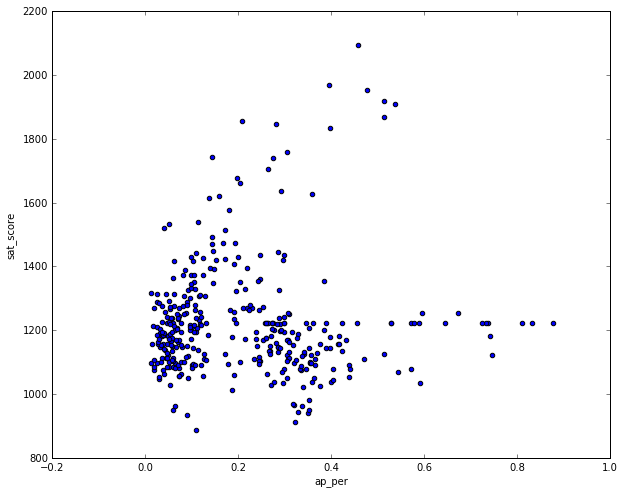

In [53]:
combined.plot.scatter("ap_per","sat_score",figsize = (10, 8))

There seems to be a weak positive relation between percentage of students who take AP exams and SAT scores.

# Last thoughts
We've done quite a bit of investigation into relationships between demographics and SAT scores in this project with some interesting findings and insights.
There's still quite a bit of analysis left to do, however. Here are some potential further leads to follow:

* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
    * If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.